In [68]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)


from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import tflscripts
import json
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from statistics import mode

In [47]:
dataset = 'synergy-final-iter5'
device = '128.237.250.218'

dataset_path = '../../datasets/' + dataset + '/'
configuration = tflscripts.read_configuration()

In [48]:
df = pd.DataFrame.from_csv(dataset_path + device + '_MICROPHONE_sst.csv')
df.index = pd.to_datetime(df.index).round('100ms')

activities = pd.DataFrame.from_csv(dataset_path + 'activities.csv')
activities.index = pd.to_datetime(activities.index).round('100ms')
activities.sort_index(inplace=True)
labels = pd.DataFrame.from_csv(dataset_path + 'activity_labels.csv')

df = df.loc[df.index.isin(activities.index)]
activities = activities.loc[activities.index.isin(df.index)]

df = df[~df.index.duplicated(keep='first')]
activities = activities[~activities.index.duplicated(keep='first')]

df = pd.concat([df, activities], axis=1)

/home/giotto/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2787: DtypeWarning: Columns (1,2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [49]:
labels['since'] = [df.loc[df.id == i].index.min() for i in labels.index]
labels['until'] = [df.loc[df.id == i].index.max() for i in labels.index]

move_window(50, by=0.1, window_length=activity_length)


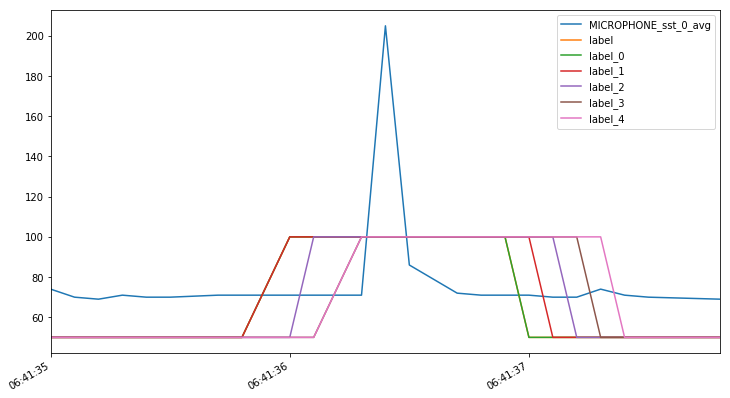

move_window(51, by=0.1, window_length=activity_length)


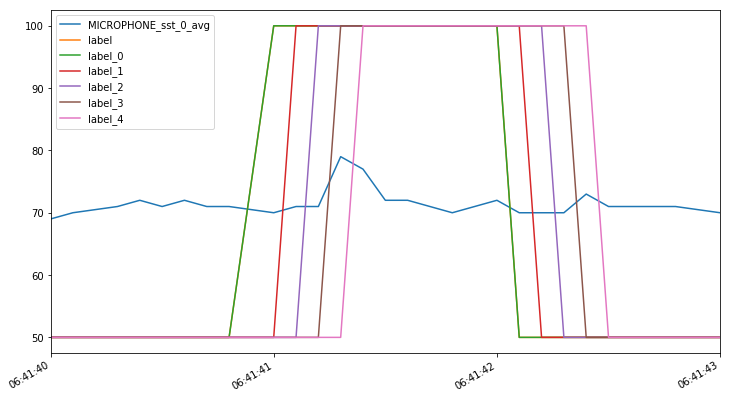

move_window(53, by=0.1, window_length=activity_length)


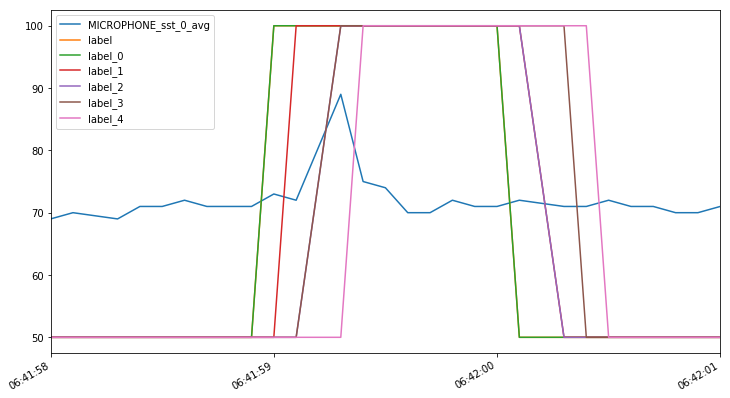

move_window(54, by=0.1, window_length=activity_length)


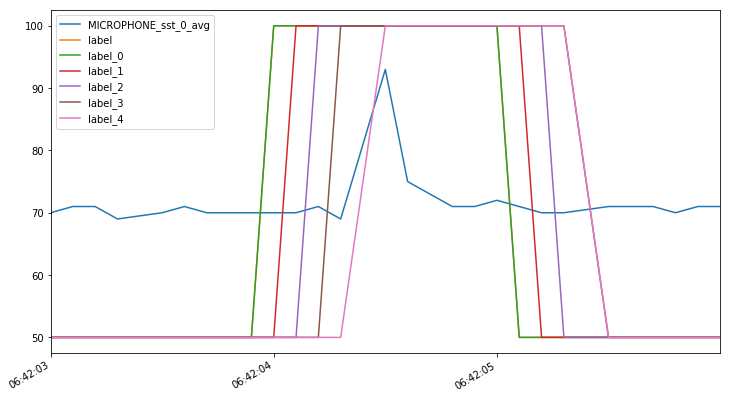

move_window(55, by=0.1, window_length=activity_length)


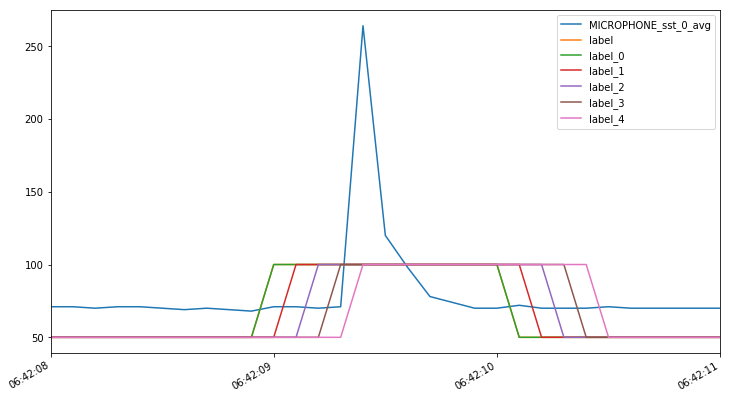

move_window(56, by=0.1, window_length=activity_length)


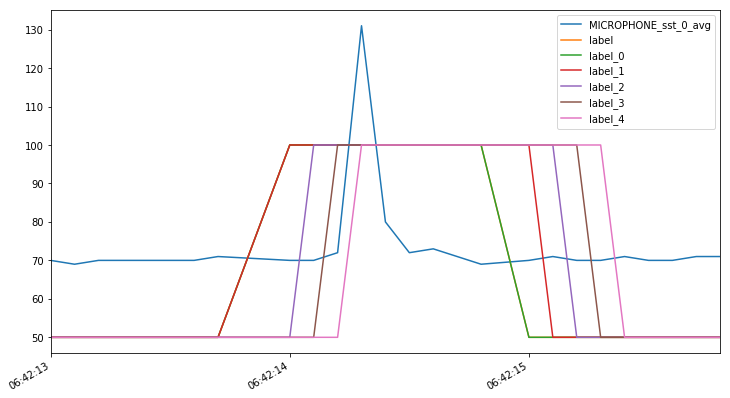

move_window(57, by=0.1, window_length=activity_length)


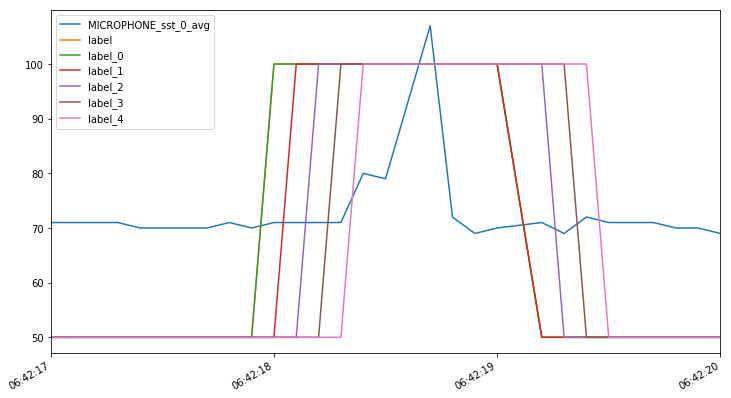

move_window(58, by=0.1, window_length=activity_length)


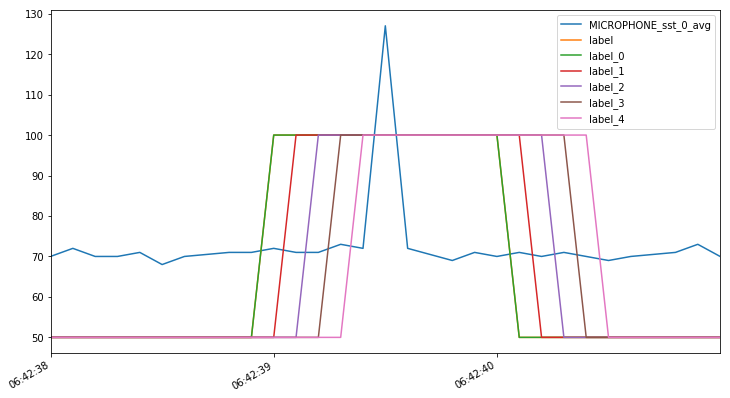

move_window(59, by=0.1, window_length=activity_length)


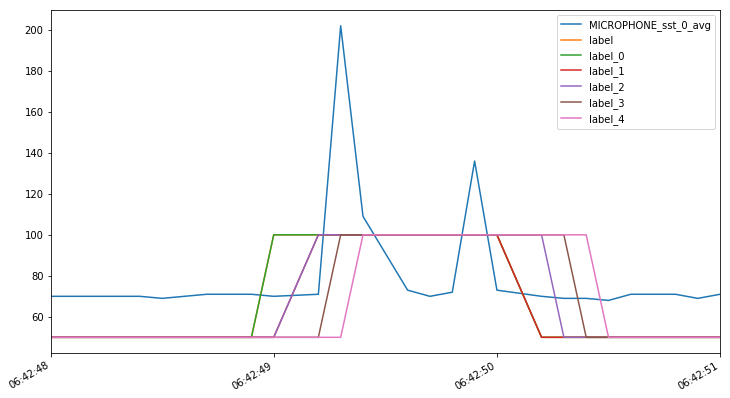

move_window(60, by=0.1, window_length=activity_length)


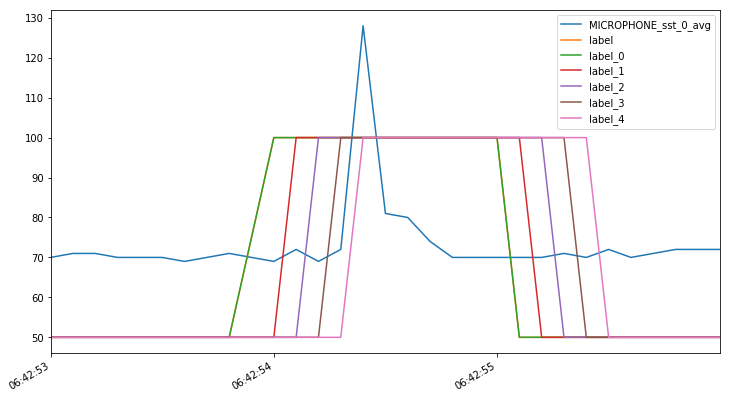

move_window(62, by=0.1, window_length=activity_length)


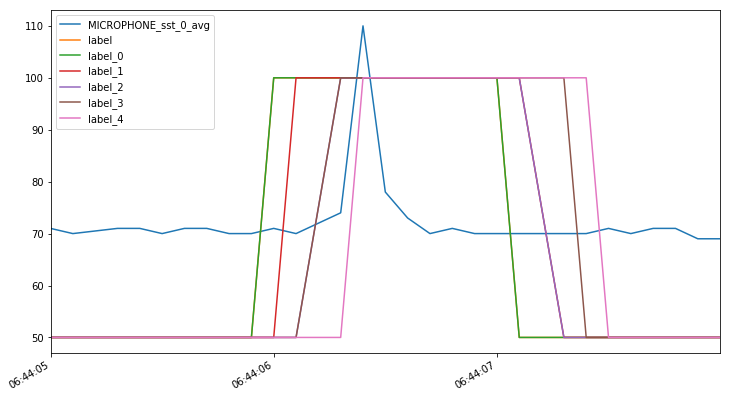

move_window(63, by=0.1, window_length=activity_length)


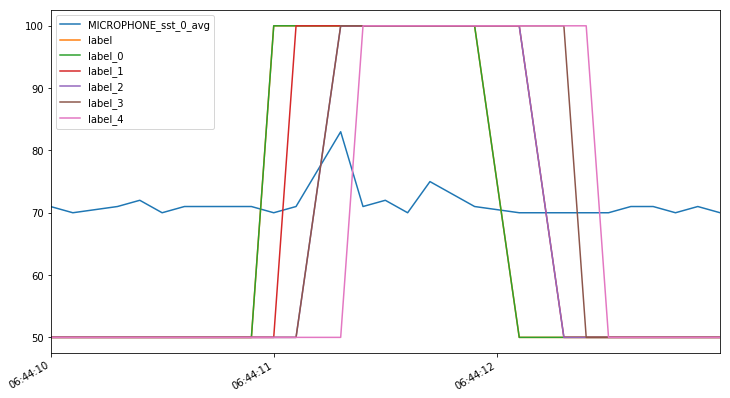

move_window(64, by=0.1, window_length=activity_length)


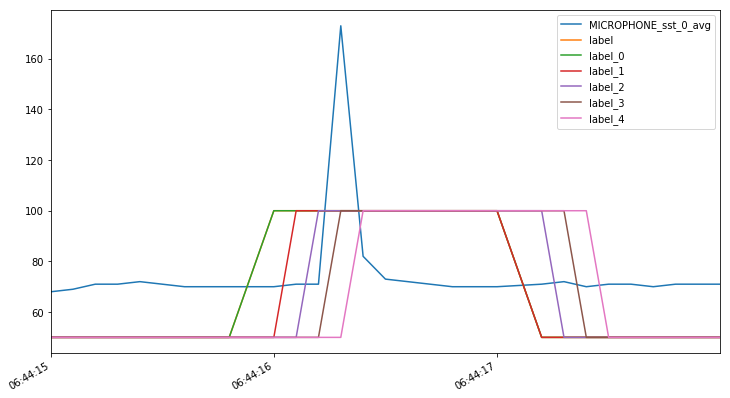

move_window(65, by=0.1, window_length=activity_length)


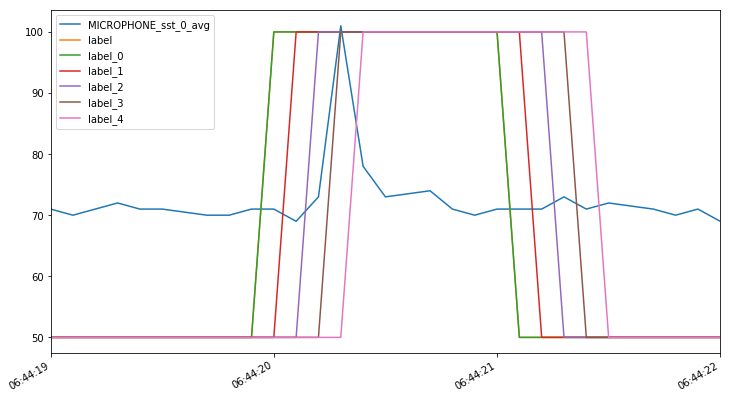

move_window(66, by=0.1, window_length=activity_length)


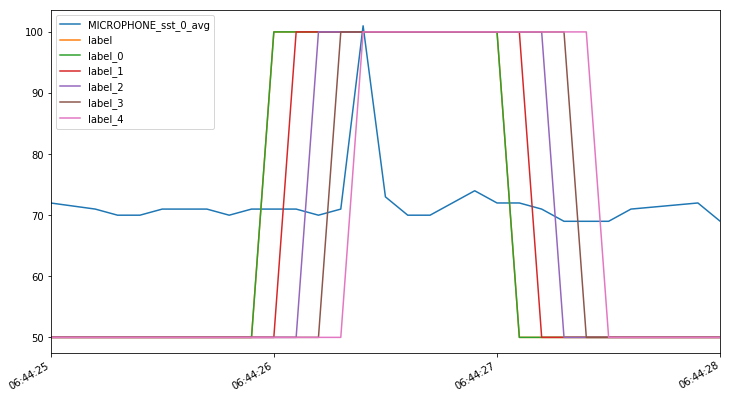

move_window(67, by=0.1, window_length=activity_length)


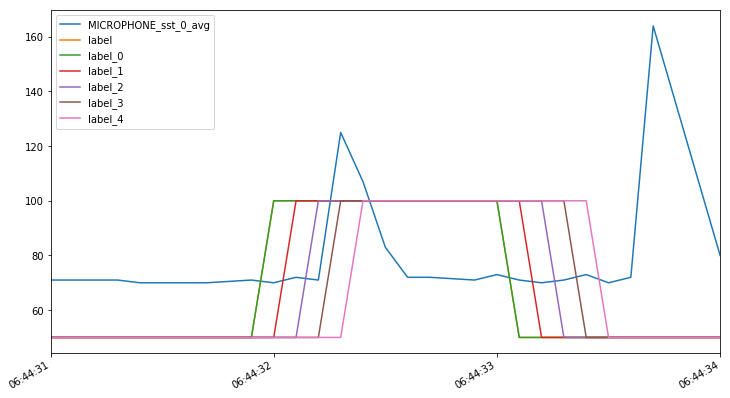

move_window(68, by=0.1, window_length=activity_length)


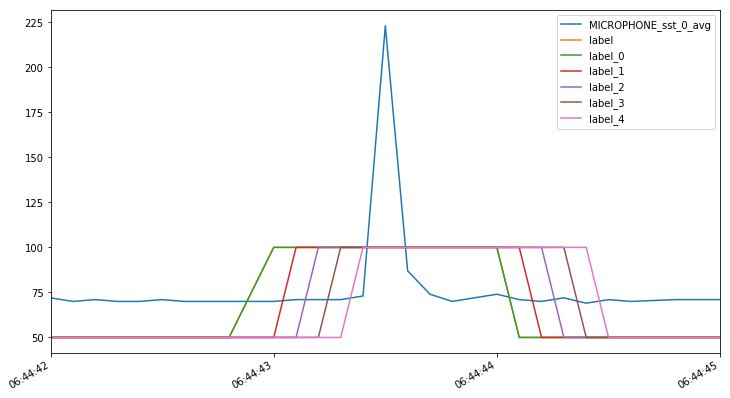

move_window(129, by=0.1, window_length=activity_length)


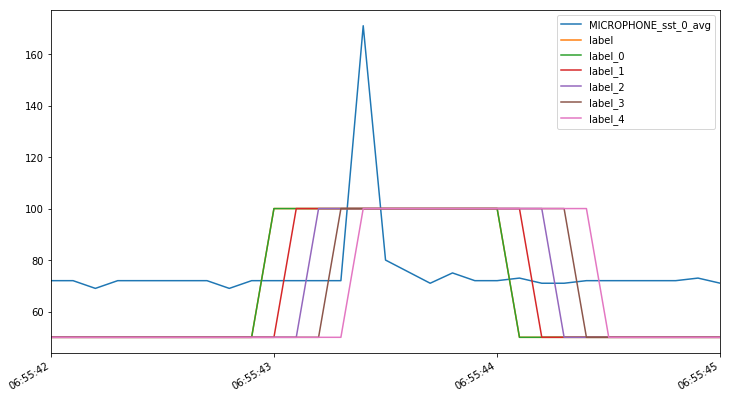

move_window(130, by=0.1, window_length=activity_length)


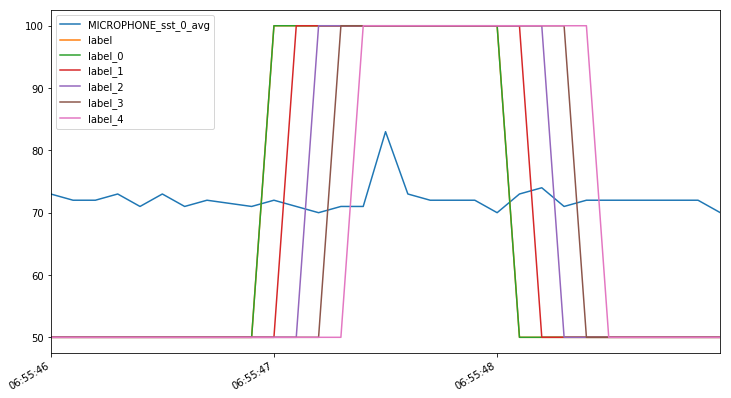

move_window(131, by=0.1, window_length=activity_length)


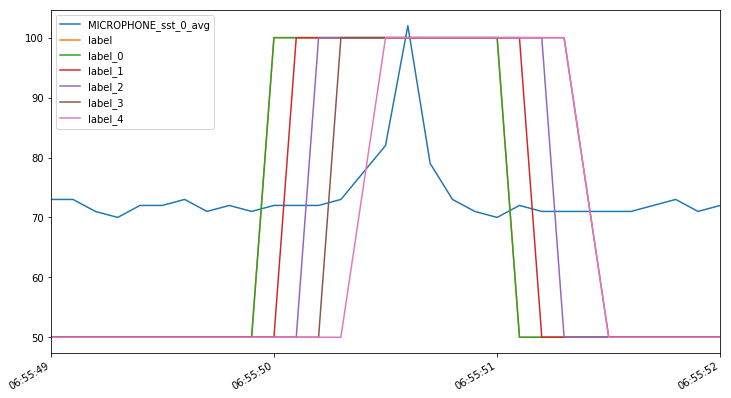

move_window(132, by=0.1, window_length=activity_length)


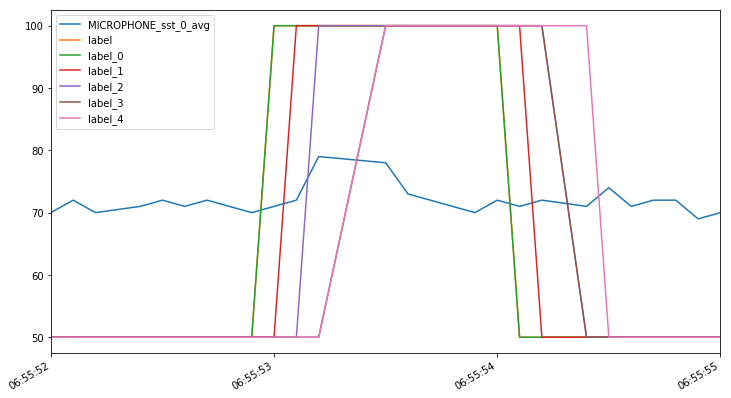

move_window(133, by=0.1, window_length=activity_length)


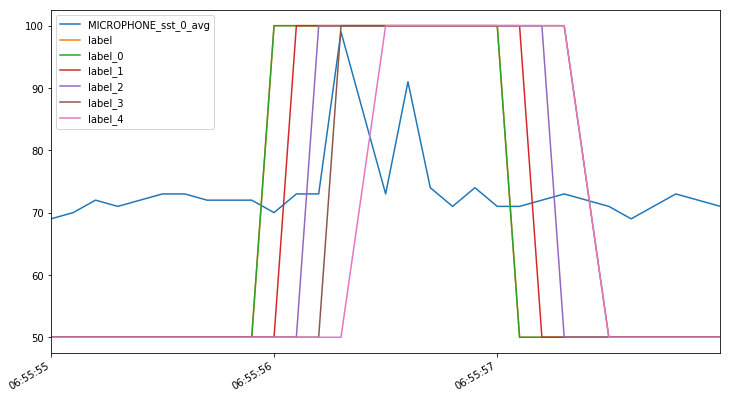

move_window(134, by=0.1, window_length=activity_length)


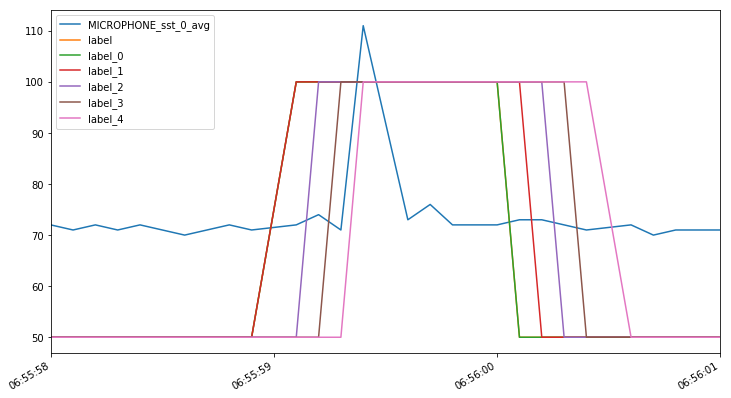

move_window(135, by=0.1, window_length=activity_length)


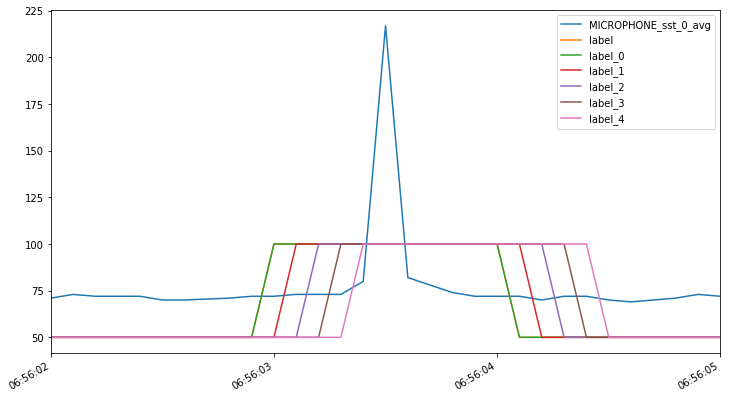

move_window(137, by=0.1, window_length=activity_length)


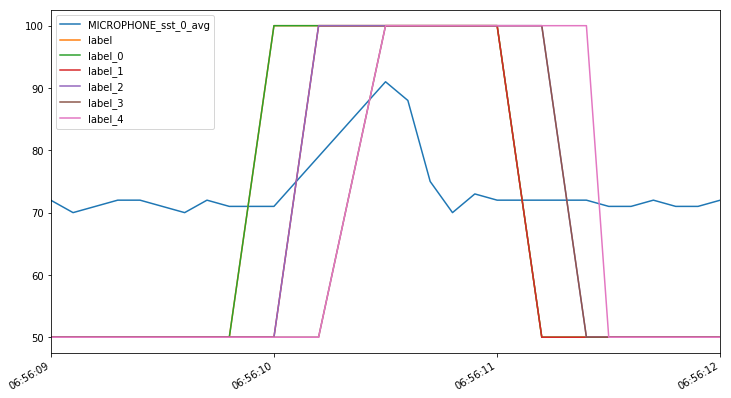

move_window(138, by=0.1, window_length=activity_length)


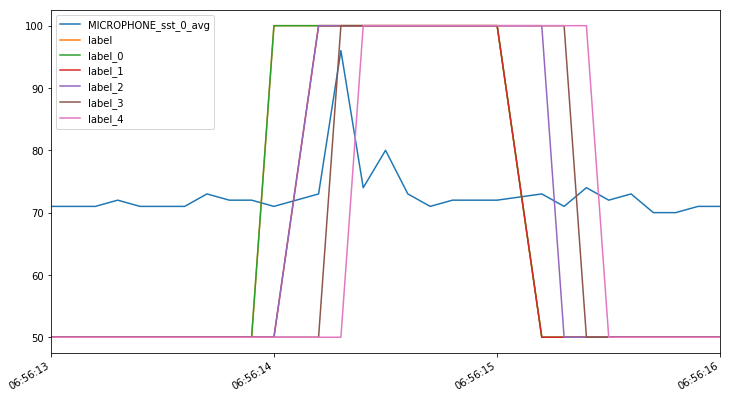

move_window(139, by=0.1, window_length=activity_length)


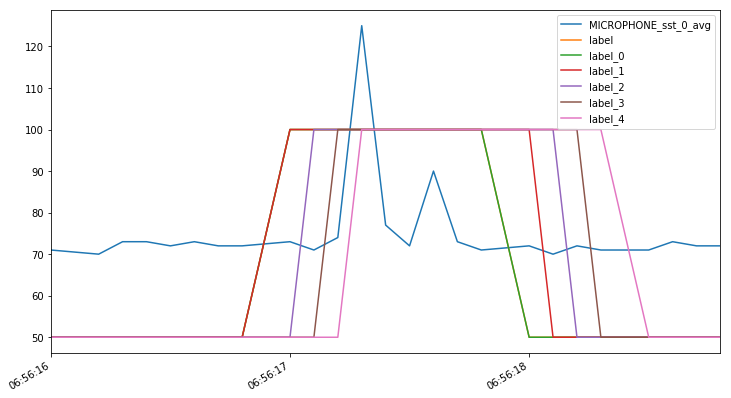

move_window(140, by=0.1, window_length=activity_length)


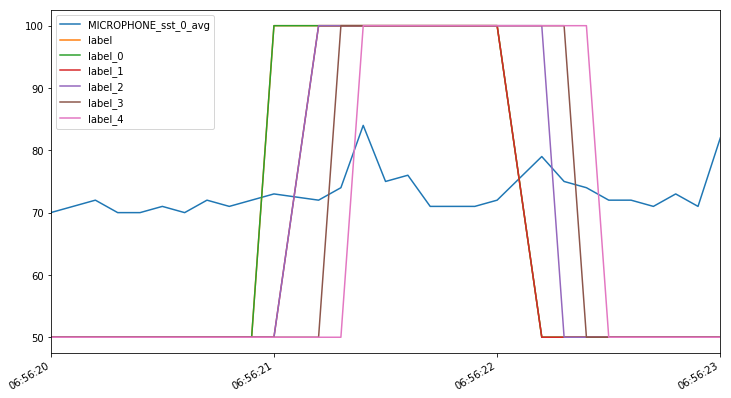

move_window(142, by=0.1, window_length=activity_length)


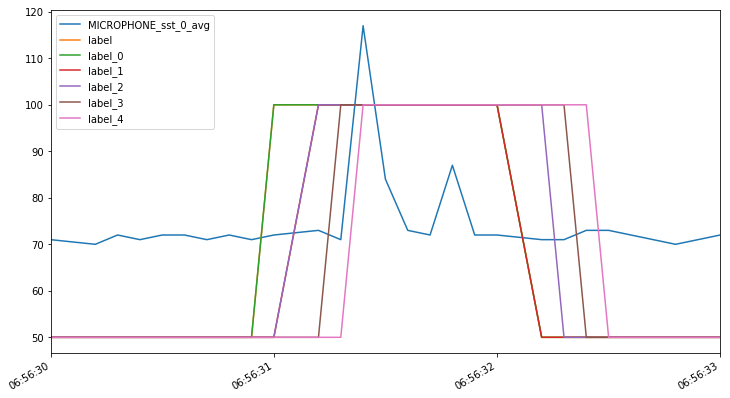

move_window(143, by=0.1, window_length=activity_length)


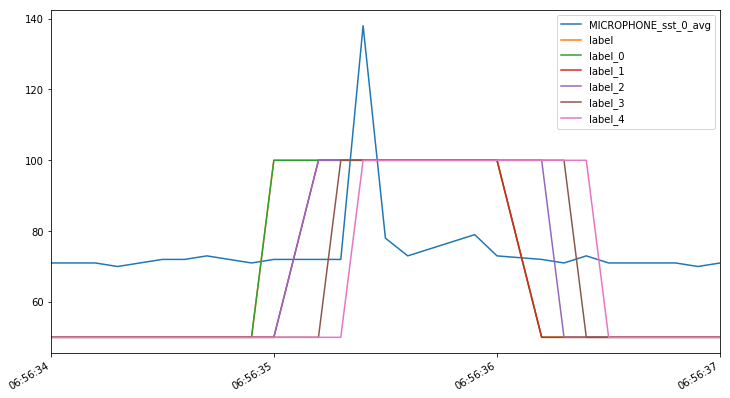

move_window(144, by=0.1, window_length=activity_length)


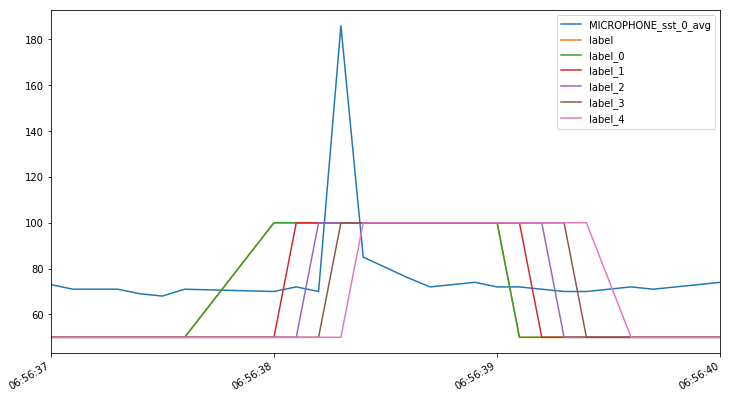

In [71]:
activity = 'Soap dispensed'
activity_length = 1

activity_labels = labels.loc[labels.label == configuration['activities'].index(activity)].copy()
activity_labels['idx'] = activity_labels.index

for idx, since, until in activity_labels[['idx', 'since', 'until']].values:
    since_ = pd.Timestamp(since) - pd.Timedelta(seconds=1)
    until_ = pd.Timestamp(until) + pd.Timedelta(seconds=1)

    since = pd.Timestamp(since)
    until = pd.Timestamp(until)
#     print(idx, since, until)
    print('move_window(' + str(idx) + ', by=0.1, window_length=activity_length)')

    subdf = df.loc[df.index >= since_]
    subdf = subdf.loc[subdf.index <= until_]
    subdf = subdf[['MICROPHONE_sst_0_avg']]
    subdf['label'] = [100 if since <= pd.Timestamp(dt) and pd.Timestamp(dt) <= until else 50 for dt in subdf.index.values]

    for i in range(5):
        since_ = pd.Timestamp(since) + pd.Timedelta(seconds=i / 10)
        until_ = pd.Timestamp(since_) + pd.Timedelta(seconds=activity_length)
        subdf['label_' + str(i)] = [100 if since_ <= pd.Timestamp(dt) and pd.Timestamp(dt) <= until_ else 50 for dt in subdf.index.values]

    subdf.plot()
#     ticks = subdf.index.values
#     plt.xticks(np.arange(0.5, len(ticks), 10), ticks[::10], rotation='vertical')
    plt.show()

In [70]:
def move_window(activity_id, by, window_length):
    since = labels[labels.index == activity_id].since.values[0]
    since_ = since + pd.Timedelta(seconds=by)
    until_ = since_ + pd.Timedelta(seconds=window_length)
    print(since_, until_)
    labels.loc[labels.index == activity_id, 'since'] = since_
    labels.loc[labels.index == activity_id, 'until'] = until_

def remove_window(activity_id):
    labels.loc[labels.index == activity_id, 'label'] = -1
    
    
move_window(50, by=-0.4, window_length=activity_length)
move_window(51, by=-0.2, window_length=activity_length)
remove_window(52)
move_window(53, by=0.0, window_length=activity_length)
move_window(54, by=0.0, window_length=activity_length)
move_window(55, by=-0.2, window_length=activity_length)
move_window(56, by=0.6, window_length=activity_length)
move_window(57, by=-0.8, window_length=activity_length)
move_window(58, by=-0.4, window_length=activity_length)
move_window(59, by=0.0, window_length=activity_length)
move_window(60, by=-0.1, window_length=activity_length)
remove_window(61)
move_window(62, by=-0.3, window_length=activity_length)
move_window(63, by=0.0, window_length=activity_length)
move_window(64, by=0.0, window_length=activity_length)
move_window(65, by=0.0, window_length=activity_length)
move_window(66, by=0.0, window_length=activity_length)
move_window(67, by=0.0, window_length=activity_length)
move_window(68, by=-0.4, window_length=activity_length)
move_window(129, by=-0.2, window_length=activity_length)
move_window(130, by=0.1, window_length=activity_length)
move_window(131, by=0.2, window_length=activity_length)
move_window(132, by=0.1, window_length=activity_length)
move_window(133, by=0.0, window_length=activity_length)
move_window(134, by=-0.2, window_length=activity_length)
move_window(135, by=0.0, window_length=activity_length)
remove_window(136)
move_window(137, by=0.0, window_length=activity_length)
move_window(138, by=-0.2, window_length=activity_length)
move_window(139, by=-0.3, window_length=activity_length)
move_window(140, by=0.3, window_length=activity_length)
remove_window(141)
move_window(142, by=0.1, window_length=activity_length)
move_window(143, by=0.3, window_length=activity_length)
move_window(144, by=0.0, window_length=activity_length)

2017-06-24 06:41:36.300000 2017-06-24 06:41:37.300000
2017-06-24 06:41:41.200000 2017-06-24 06:41:42.200000
2017-06-24 06:41:59.900000 2017-06-24 06:42:00.900000
2017-06-24 06:42:04.600000 2017-06-24 06:42:05.600000
2017-06-24 06:42:09.200000 2017-06-24 06:42:10.200000
2017-06-24 06:42:14 2017-06-24 06:42:15
2017-06-24 06:42:18.400000 2017-06-24 06:42:19.400000
2017-06-24 06:42:39.400000 2017-06-24 06:42:40.400000
2017-06-24 06:42:49 2017-06-24 06:42:50
2017-06-24 06:42:54.100000 2017-06-24 06:42:55.100000
2017-06-24 06:44:06.900000 2017-06-24 06:44:07.900000
2017-06-24 06:44:11.900000 2017-06-24 06:44:12.900000
2017-06-24 06:44:16.200000 2017-06-24 06:44:17.200000
2017-06-24 06:44:20.500000 2017-06-24 06:44:21.500000
2017-06-24 06:44:26.200000 2017-06-24 06:44:27.200000
2017-06-24 06:44:32.200000 2017-06-24 06:44:33.200000
2017-06-24 06:44:43.100000 2017-06-24 06:44:44.100000
2017-06-24 06:55:43.500000 2017-06-24 06:55:44.500000
2017-06-24 06:55:47.300000 2017-06-24 06:55:48.300000
20

In [72]:
def activity_id_for(timestamp):
    sublabels = labels.loc[labels.since <= timestamp]
    sublabels = sublabels.loc[labels.until >= timestamp]
    if len(sublabels) == 0:
        return -1
    if sublabels.label.values[0] == -1:
        return -1
    return sublabels.index.values[0]

activities['id'] = [activity_id_for(pd.Timestamp(ts)) for ts in activities.index]

In [48]:
activities.loc[activities.id == 71]

,id
2017-06-17 04:20:05.100,71
2017-06-17 04:20:05.200,71
2017-06-17 04:20:05.300,71
2017-06-17 04:20:05.400,71
2017-06-17 04:20:05.500,71
2017-06-17 04:20:05.600,71
2017-06-17 04:20:05.700,71
2017-06-17 04:20:05.800,71
2017-06-17 04:20:05.900,71
2017-06-17 04:20:06.100,71


In [73]:
activities.to_csv(dataset_path + 'activities.csv')